<a href="https://colab.research.google.com/github/jacopomanenti01/Graph-Neural-Networks/blob/main/Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task Overview

1 link prediction 1 link classification


✅ Dataset Selection
- [x] ✅Choose 1 dataset for edge-level prediction
- [x] ✅Justify your choice, highlighting its relevance and challenges.

🔪 Dataset Splitting
  - [x] ✅Apply different splitting strategies using fixed random seeds for reproducibility.
  - [x]  ✅set seed
  - [x]  ✅ Cora

🔪Use the following edge-splitting strategies:
  - [x] ✅Inductive link prediction split (unseen edges during training) (pick the correct data for such case)
  - [x] ✅Transductive link prediction split (edges within a fixed graph) (pick the correct data for such case)
  - [x] ✅Employ an 80%/20%/20% split for training, validation, and testing.
  - [x] ✅Compare the impact of these methods on performance.

✅GNN Implementation:
Implement a customized GNN using PyG’s MessagePassing module
  - [x] ✅The Graph Isomorphism Network (GIN) layer with skip connections and layer normalization.
  - [x] ✅An MLP-based message-passing mechanis for message passing.

🔗Edge-Level Tasks:

  - [x] ✅Conduct tasks like edge weight prediction, link prediction, and edge classification.
  - [ ] ✅Analyze performance across tasks and splitting strategie




# Dependecies

In [ ]:
!pip install torch torchvision torchaudio torch-geometric
!pip install --upgrade scipy networkx

import pandas as pd
import matplotlib as mpt
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from tabulate import tabulate
import numpy as np

import torch_geometric as torch_geometric
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import DataLoader
from torch.optim import Adam

import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 16.7 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.14.1 which is incompatible.


# Dataset

In [ ]:
import random

def set_seed(seed):
    """
    Fix the random seed for reproducibility.

    Parameters:
    seed (int): The seed value to use.
    """
    random.seed(seed)  # Python's built-in random module
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU (for single GPU)
    torch.cuda.manual_seed_all(seed)  # PyTorch GPU (for all GPUs)
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
    torch.backends.cudnn.benchmark = False  # Disable benchmark mode for reproducibility

In [ ]:
def  get_negative_samples(data, num_negative_samples):
  neg_samples = negative_sampling(
      edge_index = data.train_pos_edge_index,
      num_nodes = data.num_nodes,
      num_neg_samples = num_negative_samples,
  )
  return neg_samples


In [ ]:
def  get_negative_edges(egde_index, num_nodes, num_negative_samples):
  neg_samples = negative_sampling(
      edge_index = egde_index,
      num_nodes = num_nodes,
      num_neg_samples = num_negative_samples,
  )
  return neg_samples

## Inductive

In [ ]:
import torch_geometric.transforms as T
from torch_geometric.utils import train_test_split_edges, negative_sampling
from torch_geometric.datasets import TUDataset
import collections


# Set seed
set_seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Link prediction task
dataset1 = 'Cora'
path1 = '/tmp/Cora'

# set different ratios

ratio = [(.20,.20),(.10,.20), (.10,.10), (.20,.10)]

# set dict of dataset wit different splittings

datasets_splitting = collections.defaultdict(list)

# Tranformation

for i,(v,t) in enumerate(ratio):

  # Transform
  transform= T.Compose([
      T.ToDevice(device),
      T.RandomLinkSplit(num_val=v, num_test=t, is_undirected=True, add_negative_train_samples = False),
  ])

  train, val, test = Planetoid(path1,dataset1, transform= transform)[0]

  train.train_mask = train.val_mask = train.test_mask = train.y = None
  val.train_mask = val.val_mask = val.test_mask = val.y = None
  test.train_mask = test.val_mask = test.test_mask = test.y = None
  datasets_splitting[i].append(train)
  datasets_splitting[i].append(val)
  datasets_splitting[i].append(test)


In [ ]:
cora_train, cora_val, cora_test = datasets_splitting[0]
print(f'\nNumber of edges in original dataset: {Planetoid(path1,dataset1)[0]} Dataset')
print(f'\nNumber of edges in trainset: {cora_train} Dataset')
print(f'\nNumber of edges in validation set: {cora_val} Dataset')
print(f'\nNumber of edges in test set: {cora_test} Dataset')


Number of edges in original dataset: Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708]) Dataset

Number of edges in trainset: Data(x=[2708, 1433], edge_index=[2, 6336], edge_label=[3168], edge_label_index=[2, 3168]) Dataset

Number of edges in validation set: Data(x=[2708, 1433], edge_index=[2, 6336], edge_label=[2110], edge_label_index=[2, 2110]) Dataset

Number of edges in test set: Data(x=[2708, 1433], edge_index=[2, 8446], edge_label=[2110], edge_label_index=[2, 2110]) Dataset


In [ ]:
G = nx.Graph()
G.add_nodes_from(range(Planetoid(path1,dataset1)[0].num_nodes))  # Use node indices

#Generate positions for all nodes
pos = nx.spring_layout(G)

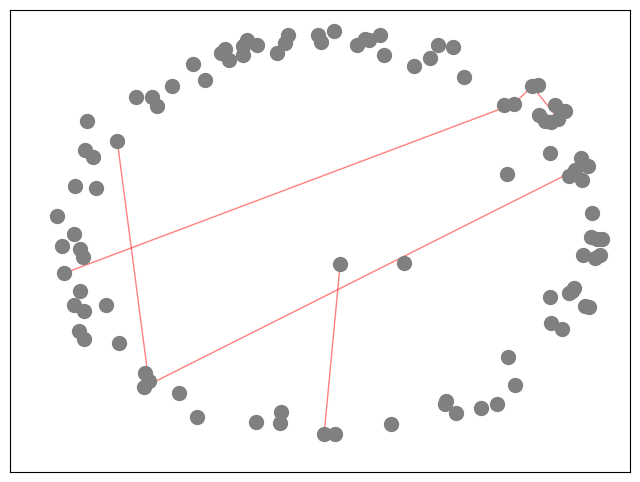

In [ ]:
import random
import matplotlib.pyplot as plt

# Select a subset of nodes to plot to create a subset
num_nodes_to_plot = 100
selected_nodes = random.sample(list(G.nodes), num_nodes_to_plot)

# Create a subgraph
subgraph = G.subgraph(selected_nodes)
sub_pos = {node: pos[node] for node in selected_nodes}  # Filter positions

# Filter train and test edges
train_list_subset = [
    edge for edge in cora_train if edge[0] in selected_nodes and edge[1] in selected_nodes
]
test_list_subset = [
    edge for edge in cora_test if edge[0] in selected_nodes and edge[1] in selected_nodes
]


# Plot the subgraph
plt.figure(figsize=(8, 6))

# Plot nodes
nx.draw_networkx_nodes(subgraph, sub_pos, node_size=100, node_color="gray")

# Plot train edges
nx.draw_networkx_edges(subgraph, sub_pos, edgelist=train_list_subset, edge_color="blue", alpha=0.5)

# Plot test edges
nx.draw_networkx_edges(subgraph, sub_pos, edgelist=test_list_subset, edge_color="green", alpha=0.5)

# Plot neg edges
train_neg_edges_ind = get_negative_edges(cora_train.edge_index, num_nodes =  Planetoid(path1,dataset1)[0].num_nodes ,num_negative_samples = cora_train.edge_index.shape[1]).t().tolist()
train_neg_edges = [
    edge for edge in train_neg_edges_ind if edge[0] in selected_nodes and edge[1] in selected_nodes
]
nx.draw_networkx_edges(subgraph, sub_pos, edgelist=train_neg_edges, edge_color="red", alpha=0.5)


plt.show()


## Transductive


In [ ]:
import torch_geometric.transforms as T
from torch_geometric.utils import train_test_split_edges, negative_sampling
from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import ZINC
import collections


# Set seed
set_seed(42)

# For link prediction task
dataset1 = 'Cora'
path1 = '/tmp/Cora'




# set dict of dataset wit different splittings

transd_splitting = collections.defaultdict(list)

# Tranformation

for i,(v,t) in enumerate(ratio):

  # Tranformation
  transform = T.Compose([
      T.NormalizeFeatures(),
      T.ToDevice(device),
  ])

  dataset_cora = Planetoid(path1,dataset1, transform= transform)[0]
  cora = train_test_split_edges(dataset_cora, val_ratio=0.2, test_ratio=0.2)

  transd_splitting[i].append(cora)



/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [ ]:
transform = T.Compose([
      T.NormalizeFeatures(),
      T.ToDevice(device),
  ])

dataset_cora = Planetoid(path1,dataset1, transform= transform)[0]

transd_splitting[0]

[Data(x=[2708, 1433], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], val_pos_edge_index=[2, 1055], test_pos_edge_index=[2, 1055], train_pos_edge_index=[2, 6336], train_neg_adj_mask=[2708, 2708], val_neg_edge_index=[2, 1055], test_neg_edge_index=[2, 1055])]

In [ ]:
G = nx.Graph()
G.add_nodes_from(range(dataset_cora.num_nodes))  # Use node indices
# Generate positions for all nodes
pos = nx.spring_layout(G)

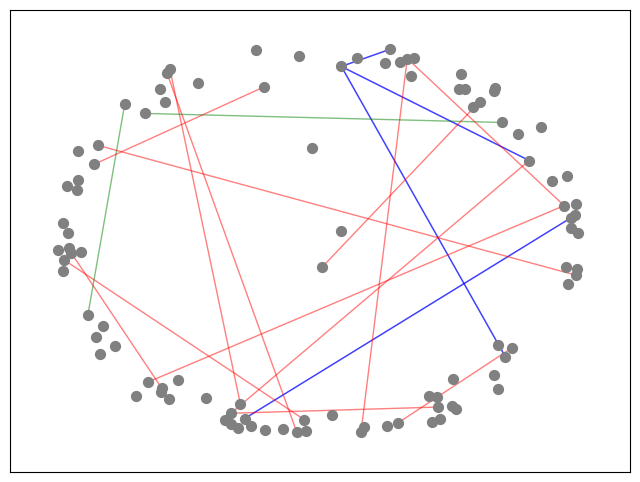

In [ ]:
import random
import matplotlib.pyplot as plt

# Select a subset of nodes to plot to create a subset
num_nodes_to_plot = 100
selected_nodes = random.sample(list(G.nodes), num_nodes_to_plot)

# Create a subgraph
subgraph = G.subgraph(selected_nodes)
sub_pos = {node: pos[node] for node in selected_nodes}  # Filter positions

# Filter train and test edges
train_list_subset = [
    edge for edge in train_list if edge[0] in selected_nodes and edge[1] in selected_nodes
]
test_list_subset = [
    edge for edge in test_list if edge[0] in selected_nodes and edge[1] in selected_nodes
]

# Plot the subgraph
plt.figure(figsize=(8, 6))

# Plot nodes
nx.draw_networkx_nodes(subgraph, sub_pos, node_size=50, node_color="gray")

# Plot train edges
nx.draw_networkx_edges(subgraph, sub_pos, edgelist=train_list_subset, edge_color="blue", alpha=0.5)

# Plot test edges
nx.draw_networkx_edges(subgraph, sub_pos, edgelist=test_list_subset, edge_color="green", alpha=0.5)

# Plot neg edges
train_neg_edges = get_negative_samples(cora, num_negative_samples = cora.train_pos_edge_index.shape[1]).t().tolist()
train_neg_edges = [
    edge for edge in train_neg_edges if edge[0] in selected_nodes and edge[1] in selected_nodes
]
nx.draw_networkx_edges(subgraph, sub_pos, edgelist=train_neg_edges, edge_color="red", alpha=0.5)


plt.show()


# GIN

In [ ]:
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.nn.inits import reset


class GINConv(MessagePassing):
    def __init__(self, nn, eps = 0.0, train_eps = False,**kwargs):
        kwargs.setdefault('aggr', 'add')
        super().__init__(**kwargs)

        self.nn = nn
        self.initial_eps = eps

        if train_eps:
            self.eps = torch.nn.Parameter(torch.empty(1))
        else:
            self.register_buffer('eps', torch.empty(1))


        self.reset_parameters()

    def reset_parameters(self):
        super().reset_parameters()
        reset(self.nn)
        self.eps.data.fill_(self.initial_eps)


    def forward(self,x,edge_index,size = None):

        out = self.propagate(edge_index, x=x, size=size)

        x_r = x[1]
        if x_r is not None:
            out = out + (1 + self.eps) * x_r

        return self.nn(out)


    def message(self, x_j):
        return x_j

    def message_and_aggregate(self, adj_t, x):
            adj_t = adj_t.set_value(None, layout=None)

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}(nn={self.nn})'

# Model

In [ ]:
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
from torch_geometric.nn import BatchNorm
import torch.nn.functional as F

class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_classes = None, link_pred = True, is_batch = True):
        super().__init__()
        self.dropout = 0.5
        self.link_pred = link_pred
        self.is_batch = is_batch

        # Sequential layers
        self.nn1 = Sequential(
            Linear(in_channels, hidden_channels),
            BatchNorm1d(hidden_channels), ReLU(),
            Linear(hidden_channels, hidden_channels), ReLU()
        )
        self.nn2 = Sequential(
            Linear(hidden_channels, hidden_channels),
            BatchNorm1d(hidden_channels), ReLU(),
            Linear(hidden_channels, out_channels), ReLU()
        )

        # Convolutional layers
        self.conv1 = GINConv(nn=self.nn1, train_eps=True)
        self.conv2 = GINConv(nn=self.nn2, train_eps=True)

        # Projection layer
        self.projection = Linear(in_channels, hidden_channels)

        # Batch normalization
        self.batch = BatchNorm1d(hidden_channels)


        if not link_pred:
            self.edge_classifier = Sequential(
                  Linear(2 * out_channels, hidden_channels),  # For concatenated embeddings
                  ReLU(),
                  Dropout(self.dropout),
                  Linear(hidden_channels, num_classes)  # Output classes
              )


    def encode(self, x, edge_index):
        res = self.projection(x) # [n_nodes, hidden_channels]
        x = self.conv1(x, edge_index).relu() # [n_nodes, hidden_channels]

        if self.is_batch:
          x = self.batch(x + res) # [n_nodes, hidden_channels]
        else:
          x += res # [n_nodes, hidden_channels]

        x = F.dropout(x, self.dropout, training=self.training) # [n_nodes, hidden_channels]
        x = self.conv2(x, edge_index) # [n_nodes, out_channels]
        return x # [n_nodes, out_channels]

    def decode(self, z, edge_label_index):
        src, dst = edge_label_index

        if not self.link_pred:
            edge_embeddings = torch.cat([z[src], z[dst]], dim=-1)  # [n_nodes, 2 * out_channels]
            x = self.edge_classifier(edge_embeddings)  # [n_nodes, num_classes]
            return x # [n_nodes, num_classes]

        return (z[src] * z[dst]).sum(dim=-1) # [n_edges]

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t() # [n_edges]

    def forward(self, x, edge_index, edge_label_index=None):
        z = self.encode(x, edge_index) # [n_nodes, out_channels]
        if not self.link_pred:
            return self.decode(z, edge_index) # [n_nodes, num_classes]
        return self.decode(z, edge_label_index).view(-1) # [n_edges]


# Initialize model
model = Net(cora_train.x.shape[1], 128, 64, is_batch=False).to(device)
print(model)




Net(
  (nn1): Sequential(
    (0): Linear(in_features=1433, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
  )
  (nn2): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
  )
  (conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=1433, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
  ))
  (conv2): GINConv(nn=Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_r

# Utilis

## Link prediction


In [ ]:
!pip install tqdm
from tqdm import tqdm



def train(epoch,
          criterion,
          data,
          model,
          lr,
          wd,
          device,
          transductive= False):
    model = model.to(device)
    n = data.x.shape[0]
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd) # 5e-4

    # initialize lists
    all_pred = []
    loss_history = []

    # initialize loss
    total_loss = 0



    for i in tqdm(range(0, epoch)):
        # set training mode
        model.train()
        # reset the grad at every batch
        opt.zero_grad()


        #egde_index, num_nodes, num_negative_samples

        if transductive:
          neg_edge_index = negative_sampling(
            edge_index=data.train_pos_edge_index, #positive edges
            num_nodes=data.num_nodes, # number of nodes
            num_neg_samples=data.train_pos_edge_index.size(1)) # number of neg_sample equal to number of pos_edges
        else:
          neg_samples_index = get_negative_edges(
              egde_index = cora_train.edge_index,
              num_nodes = data.num_nodes,
              num_negative_samples = cora_train.edge_label_index.shape[1]
          )

        # features
        x = data.x

        # edge_index
        if transductive:
          edge_index = data.train_pos_edge_index
          edge_label_index = torch.cat([edge_index,neg_edge_index], dim = -1)
        else:
          edge_index = data.edge_index
          edge_label_index = torch.cat([data.edge_label_index,neg_samples_index], dim = -1)



        # true labels
        if transductive:
          E = edge_index.size(1) + neg_edge_index.size(1)
          link_labels = torch.zeros(E, dtype=torch.float, device=device)
          link_labels[:edge_index.size(1)] = 1.
          y = link_labels
        else:
          y = torch.cat([data.edge_label,data.edge_label.new_zeros(neg_samples_index.size(1))],dim = 0)

        # output

        out = model(x, edge_index, edge_label_index)

        # compute the probs
        probs = torch.sigmoid(out)


        # compute the labels
        predicted_labels = torch.where(probs > 0.5, torch.ones_like(probs), torch.zeros_like(probs))

        # compute the loss
        loss = criterion(out, y)

        # compute gradients
        loss.backward()
        # optimize
        opt.step()

        # Accumulate loss for this batch
        total_loss += loss.item()

        if i == epoch-1:
            all_pred = predicted_labels.detach().cpu().numpy()

        if i % 100 == 0:
            loss_history.append(loss.item())
            print(f"The current loss is {loss.item():.4f}")

    avg_epoch_loss = total_loss / epoch

    return avg_epoch_loss, all_pred, loss_history

In [ ]:
from sklearn.metrics import roc_auc_score

def test(data, model, device, transductive = False):
  model.eval()

  with torch.no_grad():
            data = data.to(device)

            x = data.x
            if transductive:
              neg_edge_index = data.test_neg_edge_index
              edge_index = data.test_pos_edge_index
              edge_label_index = torch.cat([edge_index,neg_edge_index], dim = -1)

            else:
              edge_index = data.edge_index
              edge_label_index = data.edge_label_index

            if transductive:
              E = edge_index.size(1) + neg_edge_index.size(1)
              link_labels = torch.zeros(E, dtype=torch.float, device=device)
              link_labels[:edge_index.size(1)] = 1.
              y = link_labels
            else:
              y = data.edge_label


            # Forward pass through the model
            logits = model(x, edge_index, edge_label_index)

            # compute the probs
            probs = torch.sigmoid(logits)

            # compute the labels
            predicted_labels = torch.where(probs > 0.5, torch.ones_like(probs), torch.zeros_like(probs))

            # Move tensors to CPU before using NumPy
            all_pred = predicted_labels.cpu().numpy()
            all_labels = y.cpu().numpy()
            all_probs = probs.cpu().numpy()

            # Calculate ROC AUC score
            score = roc_auc_score(all_labels, probs)



            return score, all_pred, all_labels





## Others

In [ ]:
def plot_acc(ax, true_label, pred_labels, split, method):
  # Generate the confusion matrix
  cm = confusion_matrix(true_label, pred_labels)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["linked", 'not linked'])

  # Plot the confusion matrix on the specified axis
  disp.plot(ax=ax, cmap=plt.cm.Blues)
  ax.set_title(f'{method}: Confusion Matrix for Splitting {split}')

  return disp


In [ ]:
def plot_loss(ax, loss_history, epochs, model, splitting):
  x = range(0, epochs +1, 100)
  ax.plot(x,loss_history, label='train_loss')
  ax.legend()
  ax.set_title(f"{model}: Train loss. Splitting: {splitting}")
  ax.set_ylabel("CrossEntropy per epoch")
  ax.set_xlabel("Epoch")


In [ ]:
def load_model(split_key, path, app):
    model = Net(cora_train.x.shape[1], 128, 64, is_batch=True).to(device)
    checkpoint = torch.load(f'{path}/{app}_{split_key}.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # Set to evaluation mode
    return model

# Link prediction

## Inductive

### Train


In [ ]:
import collections
import os



# Set seed
set_seed(42)
criterion = nn.BCEWithLogitsLoss()

# Create dictionaries to store results for each split
split_loss_history = collections.defaultdict(list)
split_pred_history = collections.defaultdict(list)
split_final_losses = []

# Create a directory to save models if it doesn't exist
os.makedirs('saved_models', exist_ok=True)
trained_models = {}  # Dictionary to store the trained models


for k, v in datasets_splitting.items():
    cora_train = v[0]
    print(cora_train)
    epochs = 1000

    # initialize model
    model = Net(cora_train.x.shape[1], 128, 64, is_batch=True).to(device)

    # Time to train
    final_loss, pred, epoch_losses = train(epoch=epochs,
                                         criterion=criterion,
                                         data=cora_train,
                                         model=model,
                                         lr=0.01,
                                         wd=5e-4,
                                         device=device)

    # Store results for this split
    split_loss_history[k] = epoch_losses
    split_pred_history[k] = pred
    split_final_losses.append(final_loss)

    # Save the model
    model_path = f'saved_models/model_split_{k}.pt'
    torch.save({
        'model_state_dict': model.state_dict(),
        'final_loss': final_loss,
        'epoch_losses': epoch_losses,
        'split_key': k
    }, model_path)


    trained_models[k] = model

Data(x=[2708, 1433], edge_index=[2, 6336], edge_label=[3168], edge_label_index=[2, 3168])


  0%|          | 1/1000 [00:00<03:47,  4.39it/s]

The current loss is 0.9524


 10%|█         | 102/1000 [00:22<02:35,  5.79it/s]

The current loss is 0.4928


 20%|██        | 201/1000 [00:42<02:21,  5.63it/s]

The current loss is 0.4860


 30%|███       | 302/1000 [01:04<02:09,  5.37it/s]

The current loss is 0.4824


 40%|████      | 401/1000 [01:24<01:45,  5.70it/s]

The current loss is 0.4736


 50%|█████     | 501/1000 [01:56<02:24,  3.47it/s]

The current loss is 0.4763


 60%|██████    | 601/1000 [02:21<01:40,  3.97it/s]

The current loss is 0.4772


 70%|███████   | 701/1000 [02:47<01:06,  4.51it/s]

The current loss is 0.4721


 80%|████████  | 801/1000 [03:23<01:21,  2.43it/s]

The current loss is 0.4711


 90%|█████████ | 901/1000 [03:56<00:35,  2.79it/s]

The current loss is 0.4671


100%|██████████| 1000/1000 [04:33<00:00,  3.66it/s]


Data(x=[2708, 1433], edge_index=[2, 7392], edge_label=[3696], edge_label_index=[2, 3696])


  0%|          | 1/1000 [00:00<08:48,  1.89it/s]

The current loss is 1.1689


 10%|█         | 102/1000 [00:23<02:43,  5.48it/s]

The current loss is 0.5451


 20%|██        | 202/1000 [00:52<02:29,  5.34it/s]

The current loss is 0.5279


 30%|███       | 302/1000 [01:14<02:13,  5.24it/s]

The current loss is 0.5278


 40%|████      | 402/1000 [01:35<01:54,  5.22it/s]

The current loss is 0.5257


 50%|█████     | 502/1000 [02:00<01:29,  5.55it/s]

The current loss is 0.5223


 60%|██████    | 601/1000 [02:28<01:49,  3.63it/s]

The current loss is 0.5244


 70%|███████   | 701/1000 [02:54<01:43,  2.88it/s]

The current loss is 0.5207


 80%|████████  | 801/1000 [03:26<00:47,  4.15it/s]

The current loss is 0.5209


 90%|█████████ | 902/1000 [03:55<00:18,  5.18it/s]

The current loss is 0.5205


100%|██████████| 1000/1000 [04:17<00:00,  3.88it/s]


Data(x=[2708, 1433], edge_index=[2, 8448], edge_label=[4224], edge_label_index=[2, 4224])


  0%|          | 1/1000 [00:00<03:28,  4.78it/s]

The current loss is 1.0450


 10%|█         | 101/1000 [00:22<03:10,  4.71it/s]

The current loss is 0.5026


 20%|██        | 201/1000 [00:48<02:52,  4.65it/s]

The current loss is 0.4875


 30%|███       | 301/1000 [01:11<02:24,  4.83it/s]

The current loss is 0.4851


 40%|████      | 401/1000 [01:34<02:50,  3.51it/s]

The current loss is 0.4769


 50%|█████     | 501/1000 [01:59<01:42,  4.85it/s]

The current loss is 0.4756


 60%|██████    | 601/1000 [02:23<01:22,  4.83it/s]

The current loss is 0.4811


 70%|███████   | 701/1000 [02:46<01:30,  3.31it/s]

The current loss is 0.4748


 80%|████████  | 801/1000 [03:08<00:42,  4.72it/s]

The current loss is 0.4736


 90%|█████████ | 901/1000 [03:31<00:20,  4.81it/s]

The current loss is 0.4678


100%|██████████| 1000/1000 [03:54<00:00,  4.27it/s]


Data(x=[2708, 1433], edge_index=[2, 7392], edge_label=[3696], edge_label_index=[2, 3696])


  0%|          | 1/1000 [00:00<04:57,  3.36it/s]

The current loss is 1.0423


 10%|█         | 102/1000 [00:20<02:38,  5.66it/s]

The current loss is 0.5074


 20%|██        | 201/1000 [00:39<02:25,  5.50it/s]

The current loss is 0.4993


 30%|███       | 302/1000 [01:00<02:04,  5.63it/s]

The current loss is 0.4819


 40%|████      | 402/1000 [01:20<01:47,  5.58it/s]

The current loss is 0.4834


 50%|█████     | 501/1000 [01:40<02:11,  3.80it/s]

The current loss is 0.4748


 60%|██████    | 602/1000 [02:00<01:12,  5.46it/s]

The current loss is 0.4793


 70%|███████   | 702/1000 [02:19<00:53,  5.55it/s]

The current loss is 0.4710


 80%|████████  | 802/1000 [02:39<00:35,  5.66it/s]

The current loss is 0.4841


 90%|█████████ | 902/1000 [02:59<00:17,  5.48it/s]

The current loss is 0.4730


100%|██████████| 1000/1000 [03:19<00:00,  5.02it/s]


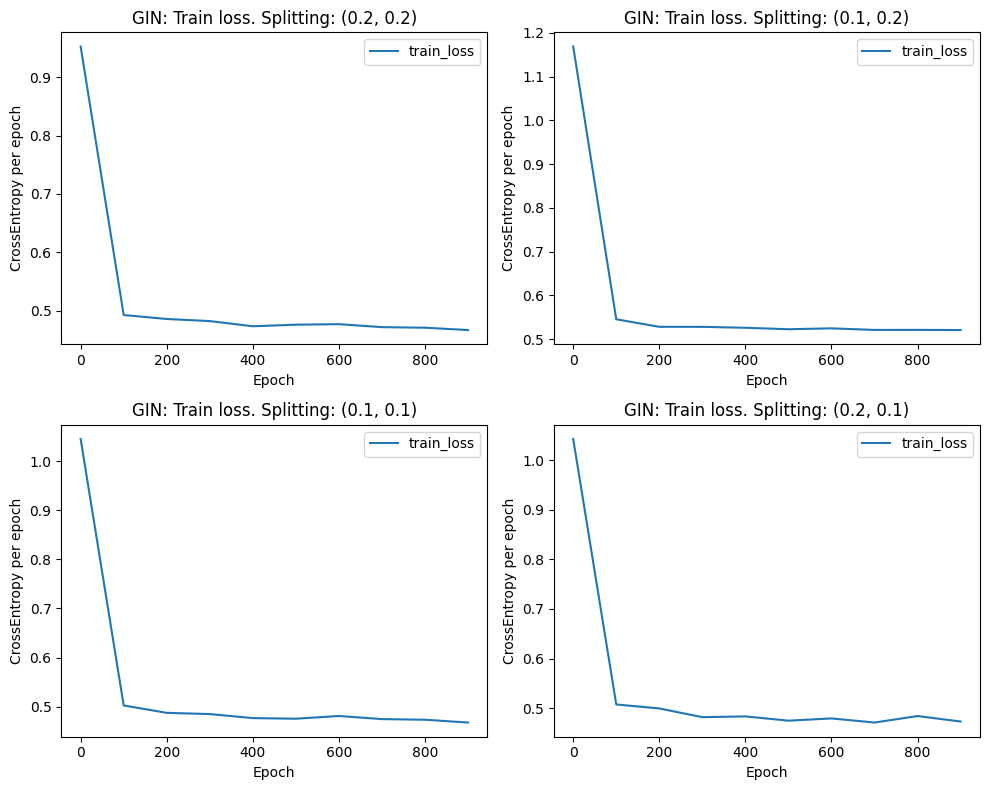

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

# Flatten the 2D array for easier iteration
axes = ax.flatten()

# Loop through loss_history and plot
for i, (key, value) in enumerate(split_loss_history.items()):
    plot_loss(axes[i], value, 999, "GIN", str(ratio[i]) )

plt.tight_layout()
plt.show()

### Test


In [ ]:
import collections



# Set seed
set_seed(42)


# Create dictionaries to store results for each split
split_y_test = collections.defaultdict(list)
test_split_pred_history = collections.defaultdict(list)
split_score = []
split_acc = []



for k, v in datasets_splitting.items():
    cora_test = v[2]

    # initialize model
    model = load_model(k)
    score, pred, y_test = test(cora_test, model, device)
    accuracy = (pred == y_test).mean().item()

    # Store results for this split
    split_y_test[k] = y_test
    test_split_pred_history[k] = pred
    split_score.append(score)
    split_acc.append(accuracy)

Data(x=[2708, 1433], edge_index=[2, 8446], edge_label=[2110], edge_label_index=[2, 2110])


<ipython-input-72-d91c461e2255>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'saved_models/model_split_{split_key}.pt')


Data(x=[2708, 1433], edge_index=[2, 8446], edge_label=[2110], edge_label_index=[2, 2110])


<ipython-input-72-d91c461e2255>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'saved_models/model_split_{split_key}.pt')


Data(x=[2708, 1433], edge_index=[2, 9502], edge_label=[1054], edge_label_index=[2, 1054])


<ipython-input-72-d91c461e2255>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'saved_models/model_split_{split_key}.pt')


Data(x=[2708, 1433], edge_index=[2, 9502], edge_label=[1054], edge_label_index=[2, 1054])


<ipython-input-72-d91c461e2255>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'saved_models/model_split_{split_key}.pt')


In [ ]:
for i, v in enumerate(split_acc):
  print('""""""""""""""""""""""""""""""""""')
  print(f"Area under the roc curve: {split_score[i]}")
  print(f"Accuracy: {v:.2f}")
  print('\n""""""""""""""""""""""""""""""""""')


""""""""""""""""""""""""""""""""""
Area under the roc curve: 0.8047290042901103
Accuracy: 0.76

""""""""""""""""""""""""""""""""""
""""""""""""""""""""""""""""""""""
Area under the roc curve: 0.7864297747130568
Accuracy: 0.73

""""""""""""""""""""""""""""""""""
""""""""""""""""""""""""""""""""""
Area under the roc curve: 0.8318774776850815
Accuracy: 0.72

""""""""""""""""""""""""""""""""""
""""""""""""""""""""""""""""""""""
Area under the roc curve: 0.8328388465014457
Accuracy: 0.78

""""""""""""""""""""""""""""""""""


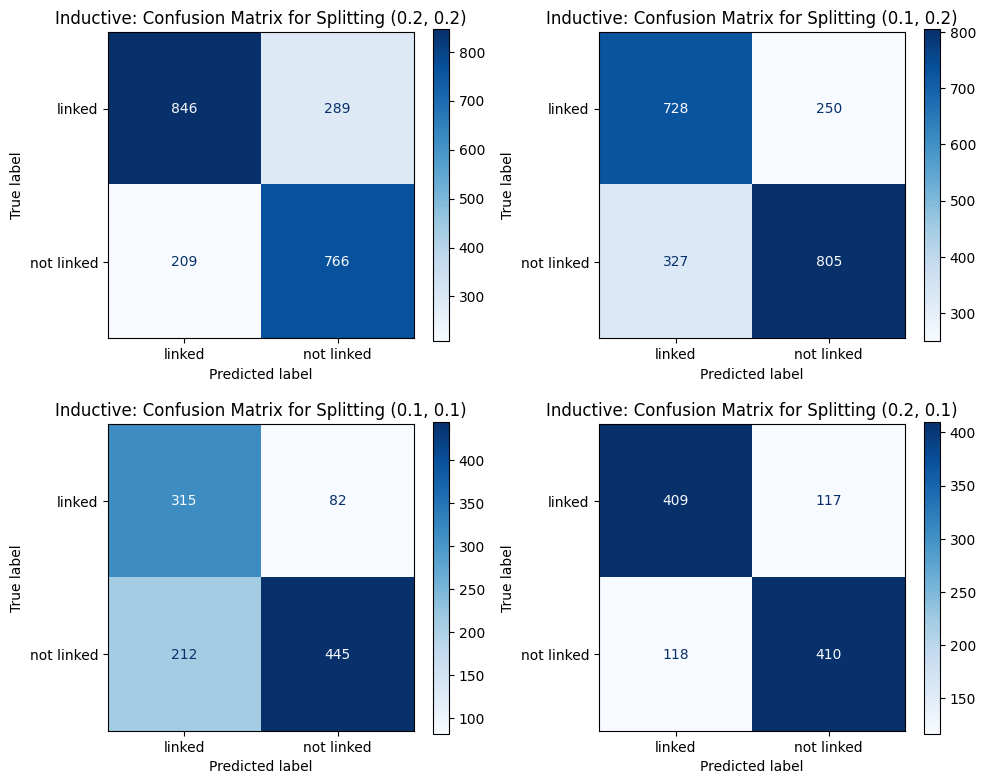

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

# Flatten the 2D array for easier iteration
axes = ax.flatten()

for i, (key, value) in enumerate(split_y_test.items()):
    plot_acc(axes[i], test_split_pred_history[i], value, str(ratio[i]), "Inductive")


plt.tight_layout()
plt.show()



## Transductive

### Train

In [ ]:
transd_splitting[0][0]

Data(x=[2708, 1433], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], val_pos_edge_index=[2, 1055], test_pos_edge_index=[2, 1055], train_pos_edge_index=[2, 6336], train_neg_adj_mask=[2708, 2708], val_neg_edge_index=[2, 1055], test_neg_edge_index=[2, 1055])

In [ ]:
import collections
import os

# Create a directory to save models if it doesn't exist
os.makedirs('saved_models_transd', exist_ok=True)

# Set seed
set_seed(42)
criterion = nn.BCEWithLogitsLoss()

# Create dictionaries to store results for each split
split_loss_history_transd = collections.defaultdict(list)
split_pred_history_transd = collections.defaultdict(list)
split_final_losses_transd = []

trained_models_sd = {}


for k, v in transd_splitting.items():
    cora = v[0]
    print(cora)
    epochs = 1000

    # initialize model
    model = Net(cora_train.x.shape[1], 128, 64, is_batch=True).to(device)

    # Time to train!

    loss, pred,loss_history = train(epoch =epochs,
                criterion = criterion,
                data = cora,
                model = model,
                lr = 0.01,
                wd = 5e-4,
                device = device,
                transductive = True)


    # Store results for this split
    split_loss_history_transd[k] = loss_history
    split_pred_history_transd[k] = pred
    split_final_losses_transd.append(loss)

    # Save the model
    model_path = f'saved_models_transd/model_split_sd_{k}.pt'
    torch.save({
        'model_state_dict': model.state_dict(),
        'final_loss': final_loss,
        'epoch_losses': epoch_losses,
        'split_key': k
    }, model_path)


    trained_models_sd[k] = model









Data(x=[2708, 1433], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], val_pos_edge_index=[2, 1055], test_pos_edge_index=[2, 1055], train_pos_edge_index=[2, 6336], train_neg_adj_mask=[2708, 2708], val_neg_edge_index=[2, 1055], test_neg_edge_index=[2, 1055])


  0%|          | 1/1000 [00:00<16:32,  1.01it/s]

The current loss is 0.9388


 10%|█         | 102/1000 [00:23<02:47,  5.36it/s]

The current loss is 0.5022


 20%|██        | 201/1000 [00:45<03:31,  3.78it/s]

The current loss is 0.4964


 30%|███       | 302/1000 [01:08<02:12,  5.26it/s]

The current loss is 0.4978


 40%|████      | 402/1000 [01:31<02:08,  4.67it/s]

The current loss is 0.4905


 50%|█████     | 501/1000 [01:58<02:16,  3.66it/s]

The current loss is 0.4942


 60%|██████    | 601/1000 [02:21<01:14,  5.34it/s]

The current loss is 0.4938


 70%|███████   | 702/1000 [02:46<00:57,  5.21it/s]

The current loss is 0.4911


 80%|████████  | 801/1000 [03:16<01:18,  2.52it/s]

The current loss is 0.4920


 90%|█████████ | 901/1000 [03:50<00:59,  1.66it/s]

The current loss is 0.4945


100%|██████████| 1000/1000 [04:22<00:00,  3.81it/s]


Data(x=[2708, 1433], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], val_pos_edge_index=[2, 1055], test_pos_edge_index=[2, 1055], train_pos_edge_index=[2, 6336], train_neg_adj_mask=[2708, 2708], val_neg_edge_index=[2, 1055], test_neg_edge_index=[2, 1055])


  0%|          | 2/1000 [00:00<03:50,  4.33it/s]

The current loss is 1.1230


 10%|█         | 102/1000 [00:31<02:47,  5.35it/s]

The current loss is 0.5237


 20%|██        | 201/1000 [00:58<03:01,  4.39it/s]

The current loss is 0.5264


 30%|███       | 302/1000 [01:19<02:06,  5.50it/s]

The current loss is 0.5165


 40%|████      | 402/1000 [01:46<01:56,  5.12it/s]

The current loss is 0.5123


 50%|█████     | 502/1000 [02:16<01:33,  5.31it/s]

The current loss is 0.5151


 60%|██████    | 601/1000 [02:37<01:49,  3.66it/s]

The current loss is 0.5136


 70%|███████   | 702/1000 [02:57<00:55,  5.33it/s]

The current loss is 0.5129


 80%|████████  | 801/1000 [03:18<00:54,  3.67it/s]

The current loss is 0.5105


 90%|█████████ | 902/1000 [03:39<00:18,  5.22it/s]

The current loss is 0.5140


100%|██████████| 1000/1000 [04:00<00:00,  4.16it/s]


Data(x=[2708, 1433], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], val_pos_edge_index=[2, 1055], test_pos_edge_index=[2, 1055], train_pos_edge_index=[2, 6336], train_neg_adj_mask=[2708, 2708], val_neg_edge_index=[2, 1055], test_neg_edge_index=[2, 1055])


  0%|          | 1/1000 [00:00<05:30,  3.02it/s]

The current loss is 0.9786


 10%|█         | 102/1000 [00:22<02:48,  5.33it/s]

The current loss is 0.4886


 20%|██        | 202/1000 [00:44<03:24,  3.91it/s]

The current loss is 0.4752


 30%|███       | 302/1000 [01:05<02:12,  5.25it/s]

The current loss is 0.4757


 40%|████      | 402/1000 [01:26<02:01,  4.91it/s]

The current loss is 0.4762


 50%|█████     | 501/1000 [01:47<01:32,  5.41it/s]

The current loss is 0.4730


 60%|██████    | 602/1000 [02:09<01:16,  5.19it/s]

The current loss is 0.4682


 70%|███████   | 702/1000 [02:29<00:59,  4.99it/s]

The current loss is 0.4761


 80%|████████  | 802/1000 [02:51<00:38,  5.21it/s]

The current loss is 0.4707


 90%|█████████ | 902/1000 [03:11<00:19,  5.13it/s]

The current loss is 0.4674


100%|██████████| 1000/1000 [03:33<00:00,  4.69it/s]


Data(x=[2708, 1433], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], val_pos_edge_index=[2, 1055], test_pos_edge_index=[2, 1055], train_pos_edge_index=[2, 6336], train_neg_adj_mask=[2708, 2708], val_neg_edge_index=[2, 1055], test_neg_edge_index=[2, 1055])


  0%|          | 2/1000 [00:00<03:22,  4.92it/s]

The current loss is 1.0511


 10%|█         | 102/1000 [00:20<02:45,  5.42it/s]

The current loss is 0.5125


 20%|██        | 202/1000 [00:43<02:32,  5.24it/s]

The current loss is 0.4939


 30%|███       | 302/1000 [01:03<02:12,  5.27it/s]

The current loss is 0.5021


 40%|████      | 402/1000 [01:25<01:53,  5.27it/s]

The current loss is 0.5013


 50%|█████     | 502/1000 [01:45<01:32,  5.41it/s]

The current loss is 0.4982


 60%|██████    | 601/1000 [02:06<01:17,  5.13it/s]

The current loss is 0.4967


 70%|███████   | 702/1000 [02:27<00:55,  5.33it/s]

The current loss is 0.4940


 80%|████████  | 802/1000 [02:48<00:37,  5.22it/s]

The current loss is 0.4958


 90%|█████████ | 902/1000 [03:08<00:18,  5.29it/s]

The current loss is 0.4967


100%|██████████| 1000/1000 [03:30<00:00,  4.75it/s]


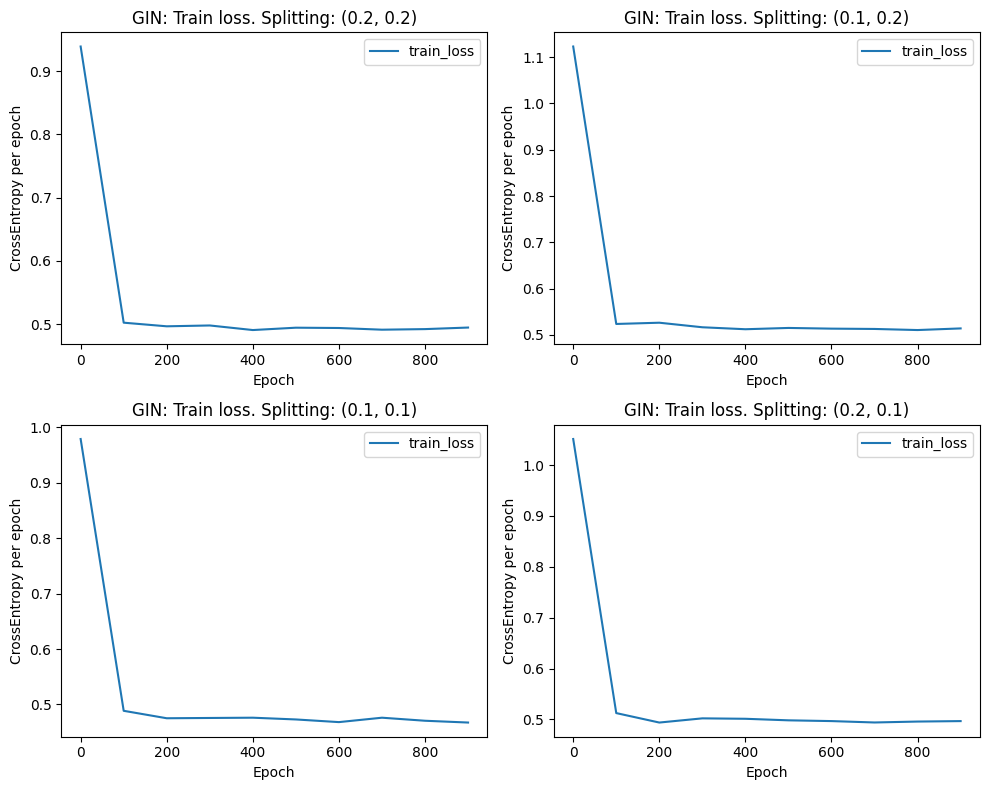

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

# Flatten the 2D array for easier iteration
axes = ax.flatten()

for i, (key, value) in enumerate(split_loss_history_transd.items()):
    plot_loss(axes[i], value, 999, "GIN", str(ratio[i]) )

# Adjust layout
plt.tight_layout()
plt.show()

### Test


In [ ]:
import collections



# Set seed
set_seed(42)


# Create dictionaries to store results for each split
split_y_test_transd = collections.defaultdict(list)
test_split_pred_history_transd = collections.defaultdict(list)
split_score_transd = []
split_acc_transd = []



for k, v in transd_splitting.items():
    cora = v[0]

    # initialize model
    model = load_model(k,"saved_models_transd", "model_split_sd" )
    score, pred, y_test = test(cora, model, device, transductive=True)
    accuracy = (pred == y_test).mean().item()

    # Store results for this split
    split_y_test_transd[k] = y_test
    test_split_pred_history_transd[k] = pred
    split_score_transd.append(score)
    split_acc_transd.append(accuracy)

<ipython-input-92-890d32a2887e>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'{path}/{app}_{split_key}.pt')
<ipython-input-92-890d32a2887e>:3: F

In [ ]:
for i, v in enumerate(split_acc_transd):
  print('""""""""""""""""""""""""""""""""""')
  print(f"Area under the roc curve: {split_score_transd[i]}")
  print(f"Accuracy: {v:.2f}")
  print('\n""""""""""""""""""""""""""""""""""')


""""""""""""""""""""""""""""""""""
Area under the roc curve: 0.5393508681296466
Accuracy: 0.54

""""""""""""""""""""""""""""""""""
""""""""""""""""""""""""""""""""""
Area under the roc curve: 0.5203782484670156
Accuracy: 0.52

""""""""""""""""""""""""""""""""""
""""""""""""""""""""""""""""""""""
Area under the roc curve: 0.5622488263965321
Accuracy: 0.43

""""""""""""""""""""""""""""""""""
""""""""""""""""""""""""""""""""""
Area under the roc curve: 0.5894364457222435
Accuracy: 0.59

""""""""""""""""""""""""""""""""""


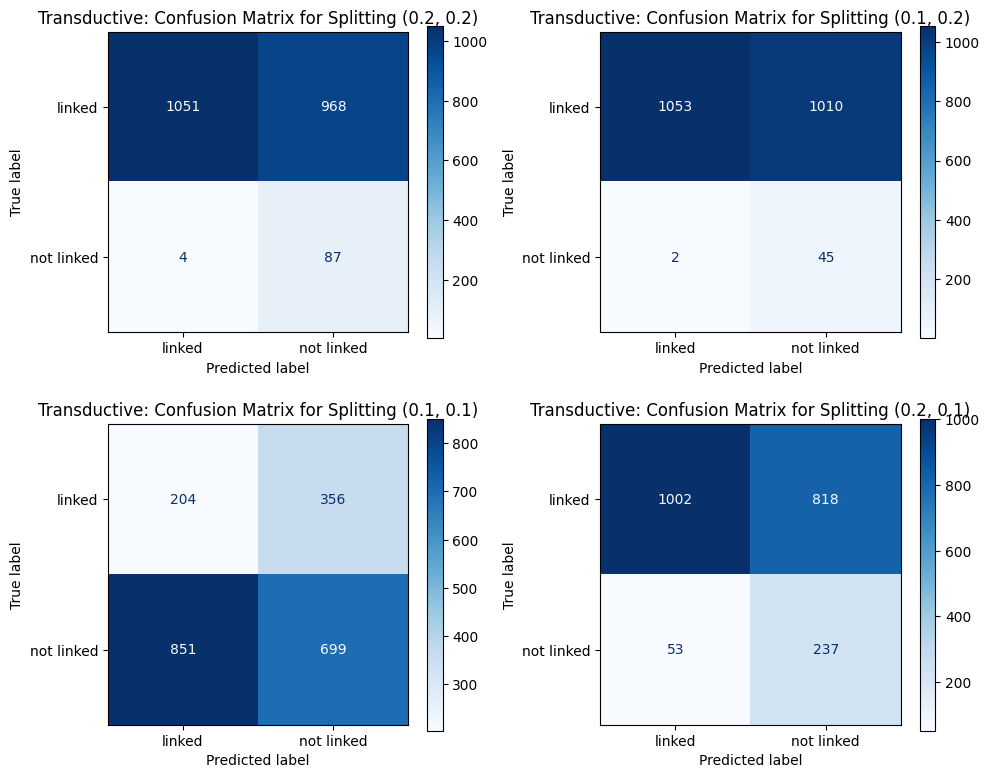

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

# Flatten the 2D array for easier iteration
axes = ax.flatten()

for i, (key, value) in enumerate(split_y_test_transd.items()):
    plot_acc(axes[i], test_split_pred_history_transd[i], value, str(ratio[i]), "Transductive")

# Adjust layout
plt.tight_layout()
plt.show()

